In [1]:
%pip install -qU duckduckgo-search langchain-community

Note: you may need to restart the kernel to use updated packages.


In [4]:
%pip install -qU langgraph

Note: you may need to restart the kernel to use updated packages.


In [7]:
%pip install -qU ddgs

Note: you may need to restart the kernel to use updated packages.


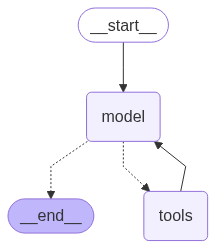

In [ ]:
import ast
from typing import Annotated,TypedDict

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.tools import tool
from langchain_ollama import ChatOllama

from langgraph.graph import START,END,StateGraph
from langgraph.graph import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


@tool
def calculator(query:str) -> str:
    """A simple calculator tool. Input should be a mathematical expression."""
    return ast.literal_eval(query)

search = DuckDuckGoSearchRun()
tools = [search, calculator]
model =ChatOllama(model="llama3.1").bind_tools(tools)

class State(TypedDict):
    messages : Annotated[list, add_messages]

def model_node(state:State):
    res = model.invoke(state["messages"])
    return {"messages": res}

builder = StateGraph(State) 
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START,"model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")
graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))


In [11]:
from langchain_core.messages import HumanMessage, SystemMessage

input = {"messages": [HumanMessage("How old was the 30th president of the USA when he died?")]}
for c in graph.stream(input):
    print(c)

{'model': {'messages': AIMessage(content='The 30th President of the United States was Calvin Coolidge. He died on January 5, 1933.\n\nCalvin Coolidge was born on July 4, 1872. Therefore, when he passed away in 1933 at the age of 60.', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2025-09-09T12:06:59.366618602Z', 'done': True, 'done_reason': 'stop', 'total_duration': 9348001502, 'load_duration': 3717743526, 'prompt_eval_count': 25, 'prompt_eval_duration': 757415002, 'eval_count': 58, 'eval_duration': 4871917444, 'model_name': 'llama3.1'}, id='run--b74c00de-5d8c-4611-a6fb-c9ed5b2bbcf9-0', usage_metadata={'input_tokens': 25, 'output_tokens': 58, 'total_tokens': 83})}}


In [ ]:
from langchain_core.messages import HumanMessage, SystemMessage

inputs = {"messages": [HumanMessage("How old was the 30th president of the USA when he died?")]}

for state in graph.stream(inputs, stream_mode="values"):
    # state is typically a dict like {"messages": [...], ...}
    messages = state.get("messages", [])
    if messages:
        msg = messages[-1]
        # For LC messages, you can call pretty_print() to get a nice output
        if hasattr(msg, "pretty_print"):
            msg.pretty_print()
        else:
            print(f"[{msg.type.upper()}] {msg.content}")


# P143

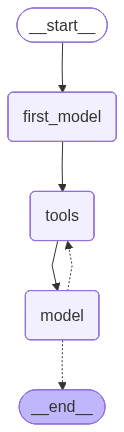

In [1]:
import ast
from typing import Annotated,TypedDict
from uuid import uuid4

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import HumanMessage, SystemMessage,AIMessage, ToolCall
from langchain_core.tools import tool
from langchain_ollama import ChatOllama

from langgraph.graph import START,StateGraph
from langgraph.graph import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


@tool
def calculator(query:str) -> str:
    """A simple calculator tool. Input should be a mathematical expression."""
    return ast.literal_eval(query)

search = DuckDuckGoSearchRun()
tools = [search, calculator]
model =ChatOllama(model="llama3.1",temperature=0.1).bind_tools(tools)

class State(TypedDict):
    messages : Annotated[list, add_messages]

def model_node(state:State):
    res = model.invoke(state["messages"])
    return {"messages": res}

def first_model(state: State) -> State:
    query =state["messages"][-1].content
    search_tool_call =ToolCall(name="duckduckgo_search", args ={"query":query}, id=uuid4().hex)
    return {"messages":AIMessage(content="",tool_calls=[search_tool_call])}


builder = StateGraph(State) 
builder.add_node("first_model", first_model)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START,"first_model")
builder.add_edge("first_model", "tools")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [13]:
input = {"messages": [HumanMessage("How old was the 30th president of the USA when he died?")]}
for c in graph.stream(input):
    print(c)

{'first_model': {'messages': AIMessage(content='', additional_kwargs={}, response_metadata={}, id='a840b308-f6de-4c6a-8906-f5bb0c078761', tool_calls=[{'name': 'duckcuck_search', 'args': {'query': 'How old was the 30th president of the USA when he died?'}, 'id': '414900e1396a4e838a08fbad3630bdd3', 'type': 'tool_call'}])}}
{'tools': {'messages': [ToolMessage(content='Error: duckcuck_search is not a valid tool, try one of [duckduckgo_search, calculator].', name='duckcuck_search', id='3d247432-fd3d-4358-9a85-661851a1a80d', tool_call_id='414900e1396a4e838a08fbad3630bdd3', status='error')]}}
{'model': {'messages': AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2025-09-09T12:40:45.784873516Z', 'done': True, 'done_reason': 'stop', 'total_duration': 7616613984, 'load_duration': 2052317937, 'prompt_eval_count': 137, 'prompt_eval_duration': 3821291654, 'eval_count': 21, 'eval_duration': 1741495811, 'model_name': 'llama3.1'}, id='run--0e2a2560-21

# P148: Multiple tools

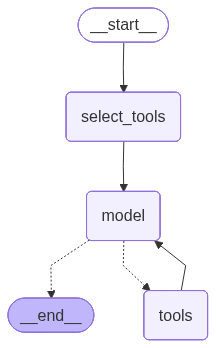

In [3]:
import ast
from typing import Annotated,TypedDict
from uuid import uuid4

from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import HumanMessage, SystemMessage,AIMessage, ToolCall
from langchain_core.tools import tool
from langchain_ollama import ChatOllama,OllamaEmbeddings
from langchain_core.vectorstores.in_memory import InMemoryVectorStore
from langchain_core.documents import Document

from langgraph.graph import START,StateGraph
from langgraph.graph import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


@tool
def calculator(query:str) -> str:
    """A simple calculator tool. Input should be a mathematical expression."""
    return ast.literal_eval(query)

search = DuckDuckGoSearchRun()
tools = [search, calculator]

embeddings = OllamaEmbeddings(model="llama3.1")
model =ChatOllama(model="llama3.1",temperature=0.1).bind_tools(tools)

tools_retriever = InMemoryVectorStore.from_documents(
    [Document(tool.description, metadata={"name": tool.name}) for tool in tools], embedding=embeddings).as_retriever()

class State(TypedDict):
    messages : Annotated[list, add_messages]
    selected_tools: list[str]

def model_node(state:State):
    selected_tools = [tool for tool in tools if tool.name in state["selected_tools"]]
    res = model.bind_tools(selected_tools).invoke(state["messages"])
    return {"messages": res}

def select_tools(state: State) -> State:
    query = state["messages"][-1].content
    tool_docs =tools_retriever.invoke(query)
    return {"selected_tools": [doc.metadata["name"] for doc in tool_docs]}


builder = StateGraph(State) 
builder.add_node("select_tools", select_tools)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START,"select_tools")
builder.add_edge("select_tools", "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()

from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [6]:
from langchain_core.messages import HumanMessage, SystemMessage

inputs = {"messages": [HumanMessage("How old was the 30th president of the USA when he died?")]}

for state in graph.stream(inputs, stream_mode="values"):
    # state is typically a dict like {"messages": [...], ...}
    messages = state.get("messages", [])
    if messages:
        msg = messages[-1]
        # For LC messages, you can call pretty_print() to get a nice output
        if hasattr(msg, "pretty_print"):
            msg.pretty_print()
        else:
            print(f"[{msg.type.upper()}] {msg.content}")


================================ Human Message =================================

How old was the 30th president of the USA when he died?
================================ Human Message =================================

How old was the 30th president of the USA when he died?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (817f93a0-4ab6-49bd-9438-b0cf64b536cd)
 Call ID: 817f93a0-4ab6-49bd-9438-b0cf64b536cd
  Args:
    query: 30th president of the USA death age
================================= Tool Message =================================
Name: duckduckgo_search

The first table charts the age of each president of the United States at the time of their inauguration, upon leaving office, and at the time of death . Presidents who are still living have their lifespans and post- presidency timespans calculated through February 17, 2026. Under President Donald Trump’s second administration, the United States has surged into a